![](./assets/img/capital-bike-share.jpg)


# Capital Bikeshare Rental Demand Forecast

### The Capstone Project for IBM Advanced Data Science Specialization Certification by Coursera

<hr>

### Abstract
In this project, I have build a neural network model and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.

<hr>

### Objective 

The objective of this project is to build a model to forecast the total number of bike rentals for 3 months
for every hour. You are provided hourly rental data spanning for 21 months. The core data set is related
to the two year historical log corresponding to years 2011 and 2012 from Capital Bike-share system,
Washington D.C., USA which is publicly available in http://capitalbikeshare.com/system-data . The
corresponding weather and seasonal information is extracted from http://www.freemeteo.com.

<hr>


## Motivation for The Case Study
A lot of startup company flourished and mushroomed to name a few: OBike, MoBike, OFO, etc are prominent few in Singapore and South East Asia. So are many in other parts of the world. But recently OBike has to pull out of business from Singapore and Australia and so other players have been facing economic viability and challenges of monetization for those who have sustained business to some extent. It was sign of bankruptcy as the business model has not succeeded as far the economic promises it has done. What could be the reason? We in this project case study try to understand if pricing, weather, or any other factor like availability of bikes in the area of demand is constantly met.

What observation and as first hand user experience of shared bike, I can safely assume the hypothesis
of pricing not a factor as it is cheapest. What is left is availability at the demand site (places) in adequate
numbers. This could be interesting to investigate using descriptive statistics to begin with and then we
aim to formulate the right hypothesis to be tested and if possible use predictive analytics to help in that
scenario.

## The Data and Data-Dictionary

![](./assets/img/bikes.png)

<hr>

# Part - I : The Ramdom Forest Approach

<hr>

In [2]:
# Getting all the necessary requirement of python and machine learning libraries
!pip3 install -r requirement.txt

In [3]:
#importing all the required libraries to be used in this task.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import missingno as ms
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

## 1.1. ETL : Data Processing & Descriptive Analysis

In [4]:
data_path = './assets/data/hour.csv' #loading the data 
hours_data = pd.read_csv(data_path)
hours_data.head(5) # visualize the top 5 records including the columns header by calling head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
# The column header is being renamed so that it can be easily readable and understood. Dropping instant and year column
# data as it is not going to provide useful information.
hours_data.rename(columns= {'weathersit':'weather','mnth':'month','hr':'hour','hum':'humidity','cnt':'count'},inplace=True)
hours_data = hours_data.drop(['dteday','instant','yr'], axis = 1) 

In [5]:
#Get the data statistics for each column 
hours_data.describe()

,season,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### 1.1.1. Data Transformation and Load : ETL

In [6]:
# Converting the columns type to category
hours_data['datetime'] = hours_data.season.astype('category')
hours_data['season'] = hours_data.season.astype('category')
hours_data['month'] = hours_data.month.astype('category')
hours_data['hour'] = hours_data.hour.astype('category')
hours_data['holiday'] = hours_data.holiday.astype('category')
hours_data['weekday'] = hours_data.weekday.astype('category')
hours_data['workingday'] = hours_data.workingday.astype('category')
hours_data['weather'] = hours_data.weather.astype('category')

hours_data.dtypes

season        category
month         category
hour          category
holiday       category
weekday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity       float64
windspeed      float64
casual           int64
registered       int64
count            int64
datetime      category
dtype: object

### 1.1.2. Missing Value and Treatment

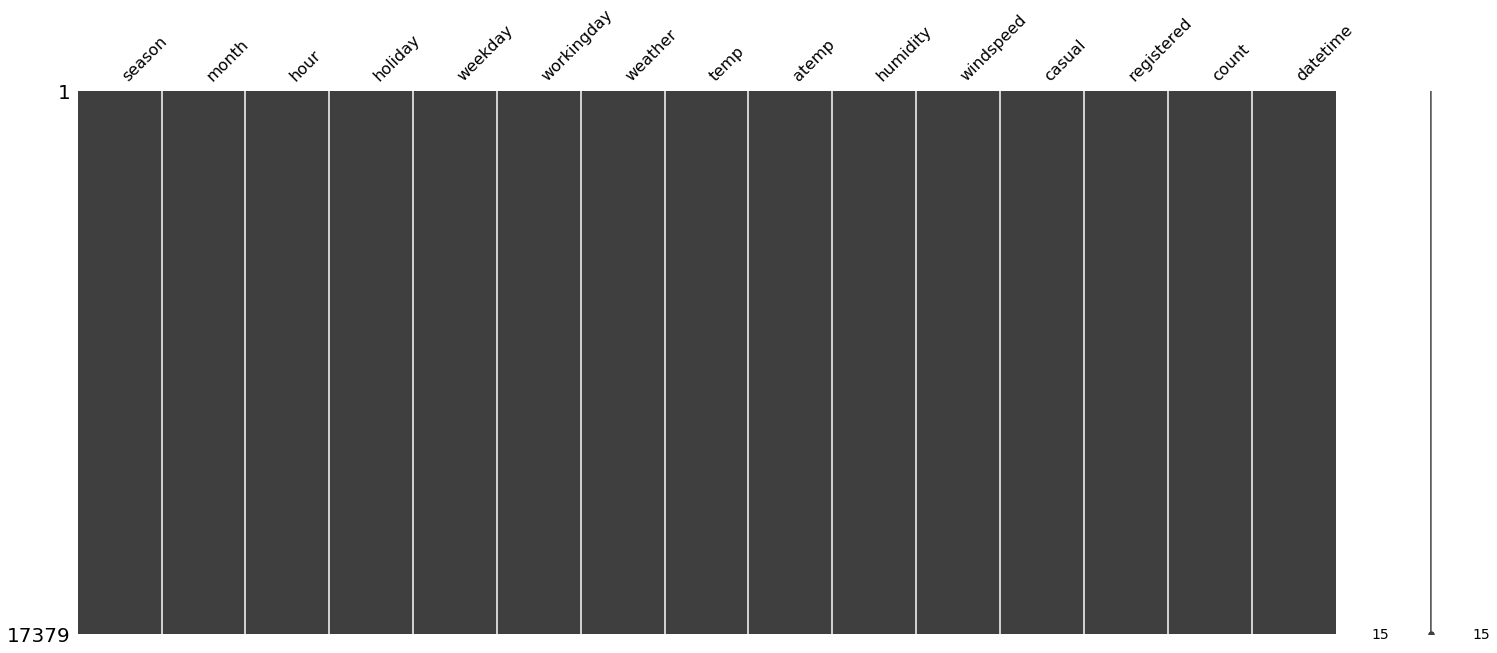

In [7]:
# Checking for any NULL value in the data
ms.matrix(hours_data)

## 1.2. Exploratory Analysis : Visual  Data Discovery

[Text(0.5, 1.0, 'Bike usage during weekdays and weekends')]

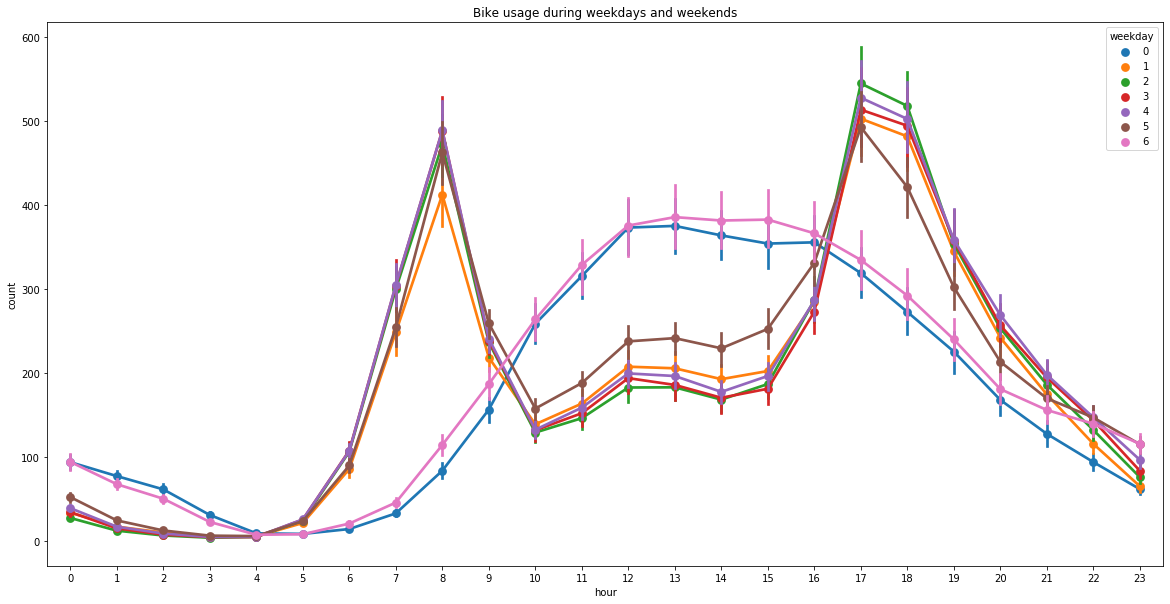

In [8]:
# Visualizing the usage of bike during weekday and weekends and the graph shows that the bikes are rented more
# during weekdays than weekends. The bike are used mostly during office hours 
fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=hours_data[['hour','count','weekday']],
            x='hour', y='count',
            hue='weekday', ax=ax, aspect=.5)
ax.set(title="Bike usage during weekdays and weekends")

[Text(0.5, 1.0, 'Bike usage during different weather condition')]

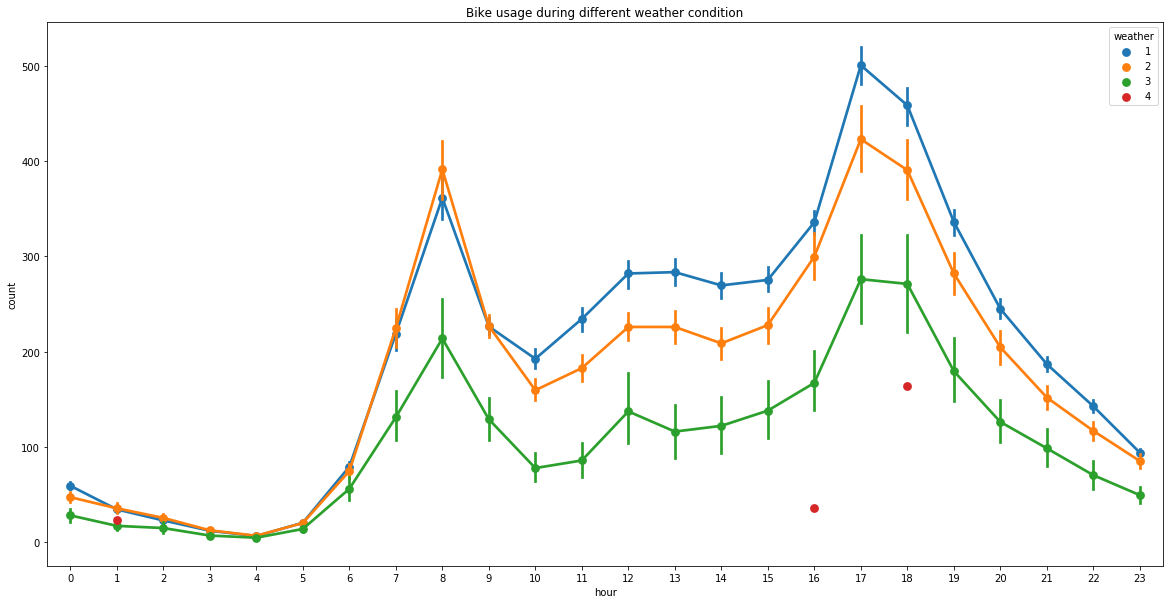

In [9]:
# Visualizing the usage of bike during different weather conditions and the graph shows that the bikes are rented
# more during weekdays than weekends. The use of bike declines once the weather condition becomes bad and there is
# almost negligible data during heavy snow and thunderstrom. 
fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=hours_data[['hour','count','weather']],
            x='hour', y='count',
            hue='weather', ax=ax, aspect=.8)
ax.set(title="Bike usage during different weather condition")

[Text(0.5, 1.0, 'Bike usage during different season')]

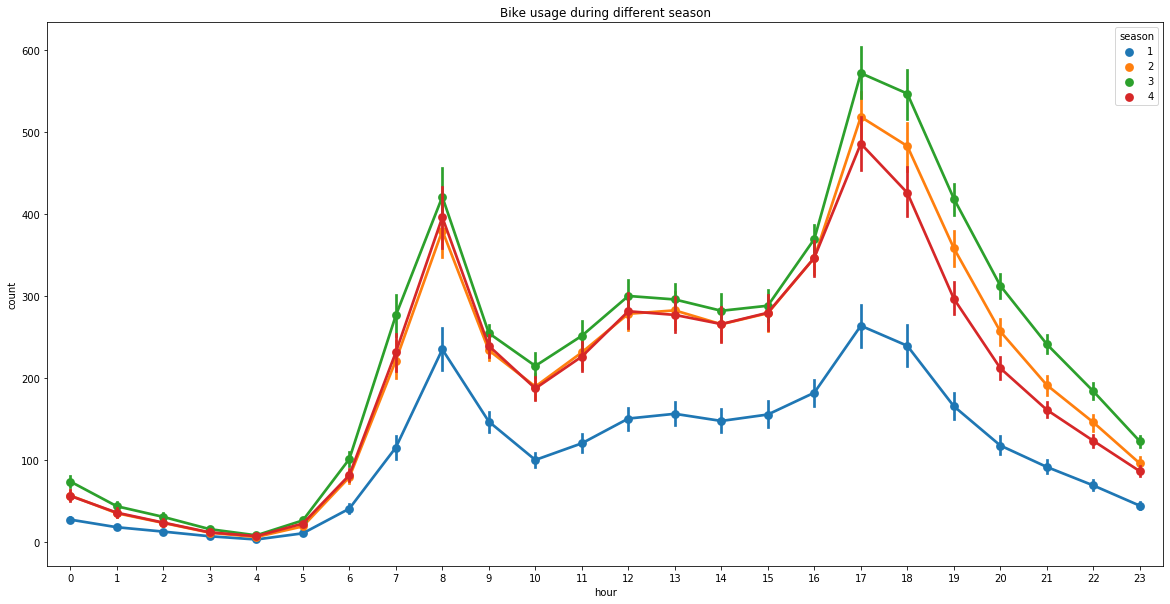

In [10]:
# Visualizing the usage of bike during different season and the graph shows that the bikes are rented more
# during fall and almost equal dring winter and summer. 
fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=hours_data[['hour','count','season']],
            x='hour', y='count',
            hue='season', ax=ax, aspect=.8)
ax.set(title="Bike usage during different season")

[Text(0.5, 1.0, 'Monthly distribution')]

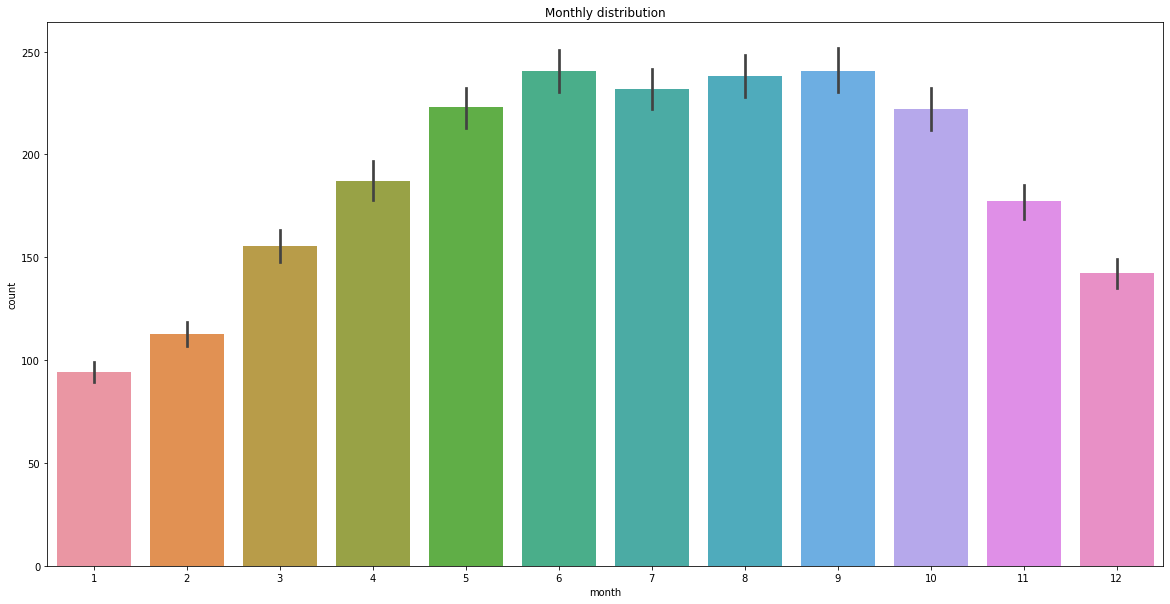

In [11]:
# The graph represents monthly distribution of data and we can see from May to October the usage of bike is at high
# compared to rest of the months
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=hours_data[['month','count']],
            x='month', y='count')
ax.set(title="Monthly distribution")

[Text(0.5, 1.0, 'Weekly distribution')]

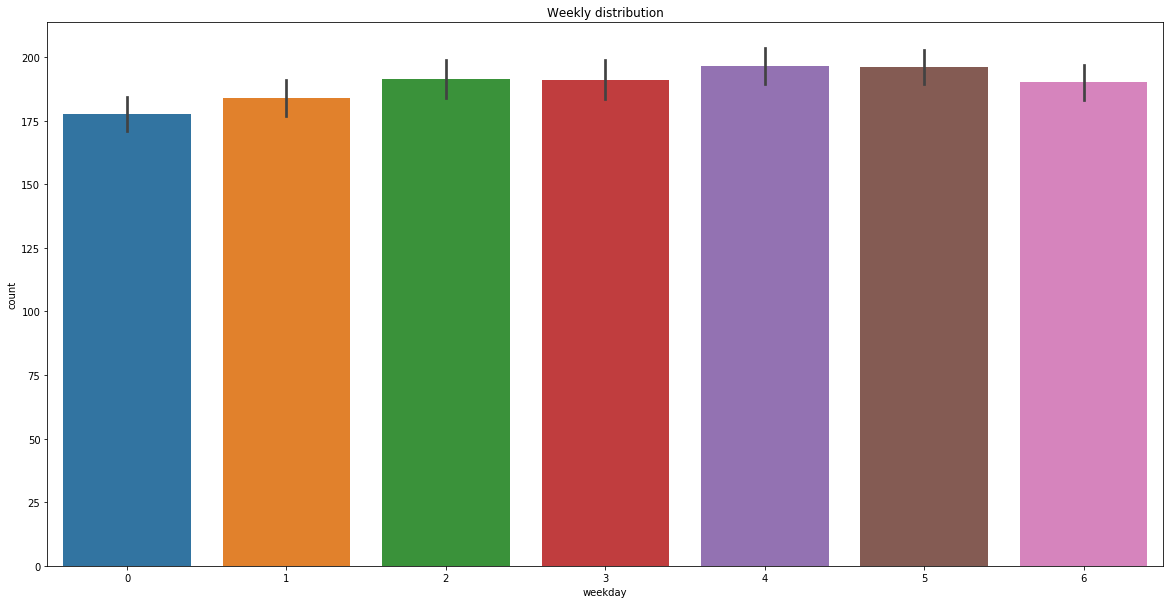

In [12]:
# The below graph represents the weekly usage of bike and we can see less variation in the data. Hence the weekly 
# distribution is not going to be much informative
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=hours_data[['weekday','count']],
            x='weekday', y='count')
ax.set(title="Weekly distribution")

In [13]:
# Splitting the raw data into X- data and y- target and visualizing its shape
y= hours_data['count']
X = hours_data.drop(['count'],axis=1)

X.shape, y.shape

((17379, 14), (17379,))

In [14]:
# Using randomForestClassifier to select best features from the raw data.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_evaluation = SelectFromModel(RandomForestClassifier(n_estimators=100))
feature_evaluation.fit(X_train,y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [15]:
feature_evaluation.get_support()

array([False, False,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True, False])

In [16]:
# The below features are best features and is ranked in descending order
selected_feature= X_train.columns[(feature_evaluation.get_support())]
print(selected_feature)

Index(['hour', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered'],
      dtype='object')


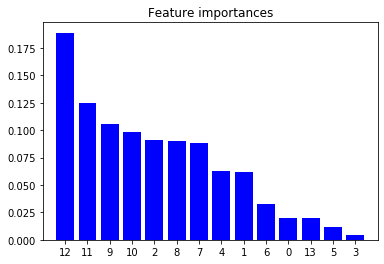

In [17]:
# Bar plot 
best_feature = feature_evaluation.estimator_.feature_importances_
indices = np.argsort(best_feature)[::-1]
# X is the train data used to fit the model 
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), best_feature[indices],
       color="b", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### 1.2.. EDA : Box Plot for Outlier Detection

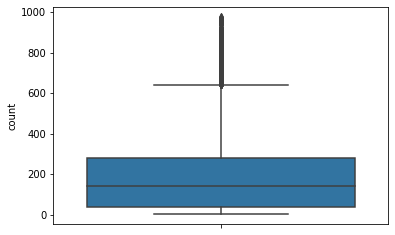

In [18]:
sns.boxplot(y=hours_data['count'])

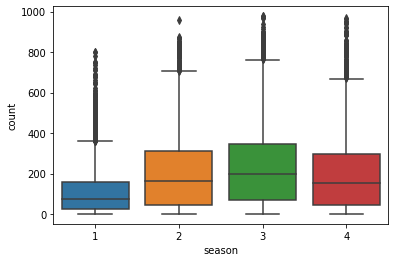

In [19]:
# The bike are used more in season 3 and season 4 and very less in seasin 1
sns.boxplot(x=hours_data['season'],y=hours_data['count'])

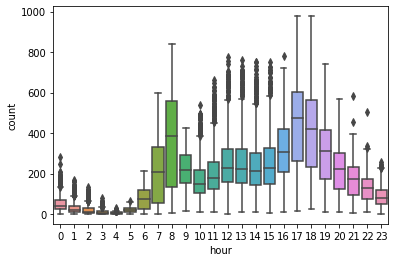

In [20]:
# The hourly box plot shows maximum usage of bike at 8am and 5pm.
sns.boxplot(x=hours_data['hour'],y=hours_data['count'])

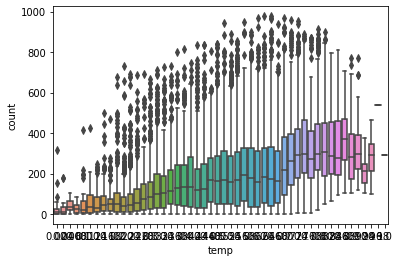

In [21]:
# Higher temperature leads to an increase in number of bike rents and lower temperature reduces also leads to
# increase in outliers in data.
sns.boxplot(x=hours_data['temp'],y=hours_data['count'])

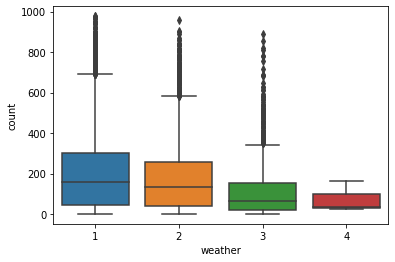

In [22]:
# The box plot shows that the bike is mostly preferred in clear weather and bright day. 
sns.boxplot(x=hours_data['weather'],y=hours_data['count'])

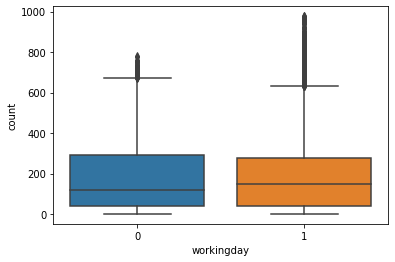

In [23]:
# The bike are rented more during working day than during weekend or holiday.
sns.boxplot(x=hours_data['workingday'],y=hours_data['count'])

### 1.2.2. EDA: Understanding Data Distribution 

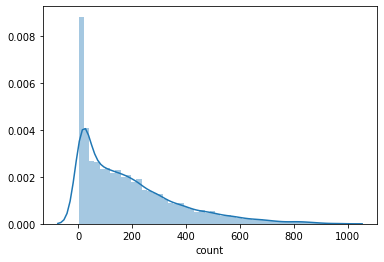

In [24]:
sns.distplot(hours_data['count'])

In [25]:
# Normalizing the data using log transform
import math

In [26]:
#hours_data['log_count']  = hours_data['count'].apply(lambda x: math.log(x))


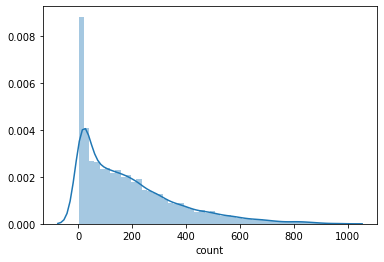

In [27]:
sns.distplot(hours_data['count'])

### 1.2.3. EDA : Correlation

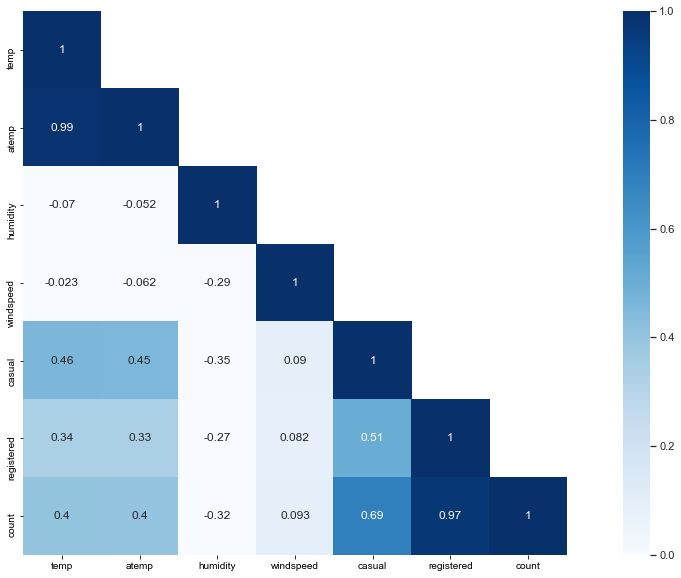

In [28]:
# Correlation Analysis
data = hours_data.corr()
heat = np.array(data)
heat[np.tril_indices_from(heat)]= False
fig, ax= plt.subplots()
fig.set_size_inches(20,10)
sns.set(font_scale=1.0)
sns.heatmap(data, mask=heat, vmax=1.0, vmin =0.0, square=True, annot=True, cmap ='Blues')
fig.savefig('Correlation analysis')

Inference: The correlation matrix shows high positive correlation between temp and atemp so we can remove atemp column. The casual and registered data contains information about the count and it could lead to data leakage, hence we can remove both of them. 

In [29]:
hours_data.shape

(17379, 15)

In [30]:
# Removing highly correlated features 
hours_data = hours_data.drop(['atemp','casual','registered'], axis = 1)
hours_data.shape

(17379, 12)

In [31]:
#One hot encoding
data_dummy = hours_data

def generate_dummies(df, dummy_column):
    dummies = pd.get_dummies(df[dummy_column], prefix=dummy_column)
    df = pd.concat([df, dummies], axis=1)
    return df

dummy_data = pd.DataFrame.copy(hours_data)
dummy_columns = ["season", "month", "hour", "holiday", "weekday",'workingday',"weather"]
for dummy_column in dummy_columns:
    dummy_data = generate_dummies(dummy_data, dummy_column)

In [32]:
# Removing the original columns
for dummy_column in dummy_columns:
    del dummy_data[dummy_column]

In [33]:
dummy_data.shape

(17379, 60)

In [34]:
dummy_data.head(5)

,temp,humidity,windspeed,count,datetime,season_1,season_2,season_3,season_4,month_1,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4
0,0.24,0.81,0.0,16,1,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
1,0.22,0.80,0.0,40,1,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
2,0.22,0.80,0.0,32,1,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
3,0.24,0.75,0.0,13,1,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
4,0.24,0.75,0.0,1,1,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0


In [35]:
# Visualizing the dimensions
y = dummy_data['count']
X = dummy_data.drop(['count'],axis=1)
print (X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(17379, 59)
(13903, 59) (3476, 59)


In [36]:
y_test = y_test.ravel()
y_test.shape

(3476,)

## 1.3. Model Creation Using Random Forest

In [44]:
regressor = RandomForestRegressor(n_estimators = 350, max_features = 'auto') 
regressor.fit(X_train,y_train)

# Predicting the values 
y_pred = regressor.predict(X_test)
y_pred = y_pred.astype(int)

In [45]:
# Printing the mean absolute error
mean_aberr = mean_absolute_error(y_test, y_pred)
print('Mean absolute error: ',mean_aberr)

Mean absolute error:  46.4168584579977


In [46]:
# printing the mean accuracy
accuracy = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv =10)
mean_acc = accuracy.mean()
print('Mean accuracy: ',mean_acc)

Mean accuracy:  0.8360245440379582


In [47]:
# Printing the root mean squared log error
RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
print('Root mean squared log error: ', RMSLE)

Root mean squared log error:  0.4577981972103363


In [120]:
# Saving the result in a csv file
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison.to_csv('results.csv')

In [121]:
comparison.head()
# do same but attach it to the dataframe
comparison['Error'] = abs(comparison.apply(lambda row: row.Actual - row.Predicted, axis=1))
comparison.head()

,Actual,Predicted,Error
0,425,373,52
1,88,97,9
2,4,13,9
3,526,424,102
4,13,26,13


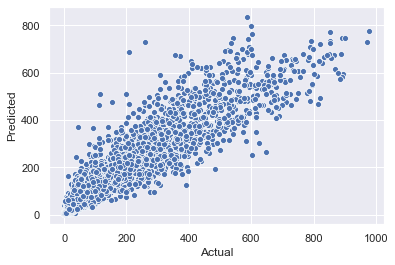

In [133]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
#ax = sns.scatterplot(x="Actual", y="Predicted", data=comparison)
#ax = sns.scatterplot(x="Actual", y="Predicted", hue="Error", data=comparison)

#rides[:24*10].plot(x='dteday', y='cnt')

markers = {"Actual": "s", "Predicted": "X"}
ax = sns.scatterplot(x="Actual", y="Predicted",
                     markers=markers,
                     data=comparison)

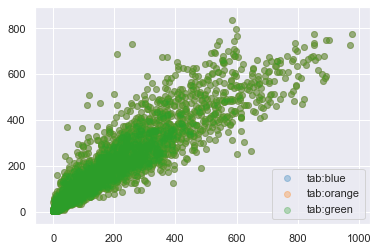

In [108]:
#ax = sns.scatterplot(x=y_test, y=y_pred)
comparison.index


import numpy as np
# np.random.seed(19680801)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for color in ['tab:blue', 'tab:orange', 'tab:green']:
#    n = 3476
#     x, y = np.random.rand(2, n)
#     scale = 200.0 * np.random.rand(n)
    ax.scatter(x="Actual", y="Predicted", c=color, label=color,
               alpha=0.3, data=comparison)

ax.legend()
ax.grid(True)

plt.show()

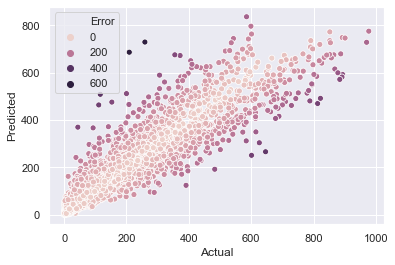

In [134]:
# The scatter plot with error as a metric of very few large errors are there. 
# Mostly result of prediction vs actual is linear
ax = sns.scatterplot(x="Actual", y="Predicted", hue="Error", data=comparison)

## 1.4. Results & Conclusion

1. The resulst are good.
2. The scatter plot with error as a metric of very few large errors are there. 
3. Mostly result of prediction vs actual is linear
4. Accuarcy rate is 83.60% and mean error is 45 which is reasonable in the sense of bike demand.
5. Accuarcy can be improvised with looking at other factors and feature engineering like seaonality, i.e. different model for different seasons could be one option worth trying, as exploratiory data analysis suggest seaonal and weather variantions.
6. However, one aspect of the data is not looked at, i.e. place and nearby places. The geocode availability could make possible the predictive power of clustered zones with spatio-and-temporal aspect for better prediction of shared bike.
7. Another data is telecom, to be factored in for people footfall and density may translate into better prediction. However these data are not available.
8. With same data we can use some neural network techniques. This will be next step. 

# Next Step : Neural Network Model
## [Neural Network Model](Capital-Bikeshare-Rental-Demand-Forecast-2-Neural-Network.ipynb)
